In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from utilities.controllers import LQRController, TVLQRController
from utilities.prepareTrajectory import prepare_trajectory
from utilities.plant import PendulumPlant_, PendulumPlantApprox
from utilities.plot import quad_form,get_ellipse_patch, plotFunnel, plotFunnel3d, sample_from_ellipsoid
from utilities.simulation import Simulator
from timeInvSOS.TI_SOSroa import SOSequalityConstrained
from nominalTrajectory.directCollocation import DirectCollocationCalculator
from SosBilinearAlternation import TVmultSearch, TVrhoSearch

# Parameters initialization

In [2]:
# pendulum parameters
mass = 0.57288
length = 0.5
damping = 0.15
gravity = 9.81
coulomb_fric = 0.0
torque_limit = 1.5
inertia = mass*length*length

# swingup parameters
x0 = [0.0, 0.0]
goal = [np.pi, 0.0]

# direct collocation parameters, N is chosen also to be the number of knot points
N = 60
max_dt = 0.05

# Compute the nominal trajectory via direct collocation

In [3]:
dircal = DirectCollocationCalculator()
dircal.init_pendulum(mass=mass,
                     length=length,
                     damping=damping,
                     gravity=gravity,
                     torque_limit=torque_limit)
x_trajectory, dircol, result = dircal.compute_trajectory(N=N,
                                                         max_dt=max_dt,
                                                         start_state=x0,
                                                         goal_state=goal)
T, X, XD, U = dircal.extract_trajectory(x_trajectory, dircol, result, N=N)

# save results
log_dir = "nominalTrajectory/log_data"
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

csv_data = np.vstack((T, X, XD, U)).T
csv_path = os.path.join(log_dir, "trajectory.csv")
np.savetxt(csv_path, csv_data, delimiter=',',
           header="time,pos,vel,torque", comments="")

# Funnel Computation

In [4]:
def TVSOSrhoBiAlternation(pendulum, controller, time, N, rhof):

    # Initial rho(t) definition (exponential init)
    c = 2
    rho_init = np.exp(c*(time-time[-1])/time[-1])
    rho_init[-1] = rhof
    rho_t = rho_init
    rho_t_prev = rho_t
    
    # Bilinear SOS alternation for improving the first guess
    convergence = False
    eps = 0.1
    while(not convergence):
        fails = 0
        for knot in np.flip([i for i in range(1,round(N))]):
            print("---------------")
            print(f"Knot {knot-1}:")

            fail = True
            while(fail):
                # Search for a multiplier, fixing rho
                (fail, h_map) = TVmultSearch(pendulum, controller, knot, time, rho_t)
                if fail:
                    rho_t[knot-1] = 0.75*rho_t[knot-1]

            # Search for rho, fixing the multiplier       
            (fail, rho_opt) = TVrhoSearch(pendulum, controller, knot, time, h_map, rho_t)
            if fail:
                rho_opt = rho_t[knot-1]
                fails = fails+1
            else:
                print("RHO IMPROVES!!")

            rho_t[knot-1] = rho_opt

            print(rho_t)
            print("---------------")
        
        # Check for convergence
        if((np.sum(rho_t) - np.sum(rho_t_prev))/np.sum(rho_t_prev) < eps): 
            convergence = True
        rho_t_prev = rho_t
    
    if (fails != 0):
        print(f"{fails} fails has been experienced in the estimation.")

    return (rho_t, controller.tvlqr.S)


---------------
Knot 58:
RHO IMPROVES!!
[0.13533528 0.14000156 0.14482873 0.14982234 0.15498812 0.16033202
 0.16586017 0.17157893 0.17749487 0.18361479 0.18994572 0.19649493
 0.20326996 0.21027858 0.21752886 0.22502913 0.232788   0.24081439
 0.24911752 0.25770695 0.26659253 0.27578448 0.28529336 0.29513011
 0.30530601 0.31583278 0.32672251 0.3379877  0.34964132 0.36169674
 0.37416783 0.38706891 0.40041481 0.41422088 0.42850296 0.44327749
 0.45856143 0.47437235 0.49072843 0.50764845 0.52515186 0.54325878
 0.56199002 0.5813671  0.60141229 0.62214862 0.64359993 0.66579087
 0.68874694 0.71249453 0.73706091 0.76247433 0.78876398 0.81596009
 0.84409391 0.87319776 0.90330509 0.93445051 1.26292961 1.33043777]
---------------
---------------
Knot 57:
RHO IMPROVES!!
[0.13533528 0.14000156 0.14482873 0.14982234 0.15498812 0.16033202
 0.16586017 0.17157893 0.17749487 0.18361479 0.18994572 0.19649493
 0.20326996 0.21027858 0.21752886 0.22502913 0.232788   0.24081439
 0.24911752 0.25770695 0.2665925

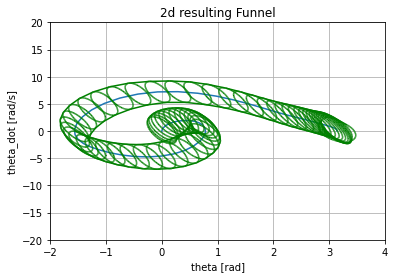

In [5]:
# load results
csv_path = "nominalTrajectory/log_data/trajectory.csv"
data_dict = prepare_trajectory(csv_path)
trajectory = np.loadtxt(csv_path, skiprows=1, delimiter=",")
time = trajectory.T[0].T
dt = time[1]-time[0]
x0_traj = [trajectory.T[1].T, trajectory.T[2].T]

# Initializing the pendulum plant
pendulum = PendulumPlant_(mass=mass,
                         length=length,
                         damping=damping,
                         gravity=gravity,
                         coulomb_fric=coulomb_fric,
                         inertia=None,
                         torque_limit=torque_limit)

# Initializing the TVLQR controller
controller = TVLQRController(data_dict=data_dict, mass=mass, length=length,
                             damping=damping, gravity=gravity,
                             torque_limit=torque_limit)
controller.set_goal(goal)

# Taking the final value of rho from the time invariant case, SOS method has been chosen
(rhof, Sf) = SOSequalityConstrained(pendulum,LQRController(mass=mass,
                                                            length=length,
                                                            damping=damping,
                                                            gravity=gravity,
                                                            torque_limit=torque_limit))

# Application of the algorithm for time-variand RoA estimation
(rho, S) = TVSOSrhoBiAlternation(pendulum, controller, time, N, rhof)

plotFunnel(rho, S,x0_traj, time)
print("The final rho is: "+str(rho))

# Funnel Verification

Verification of the knot 0...
Verification of the knot 10...
Verification of the knot 20...
Verification of the knot 40...


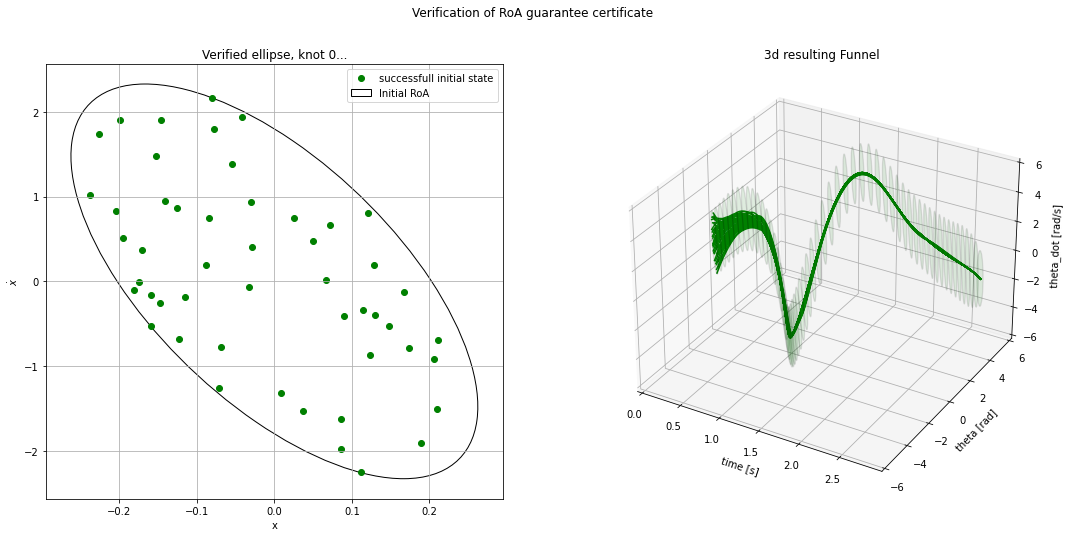

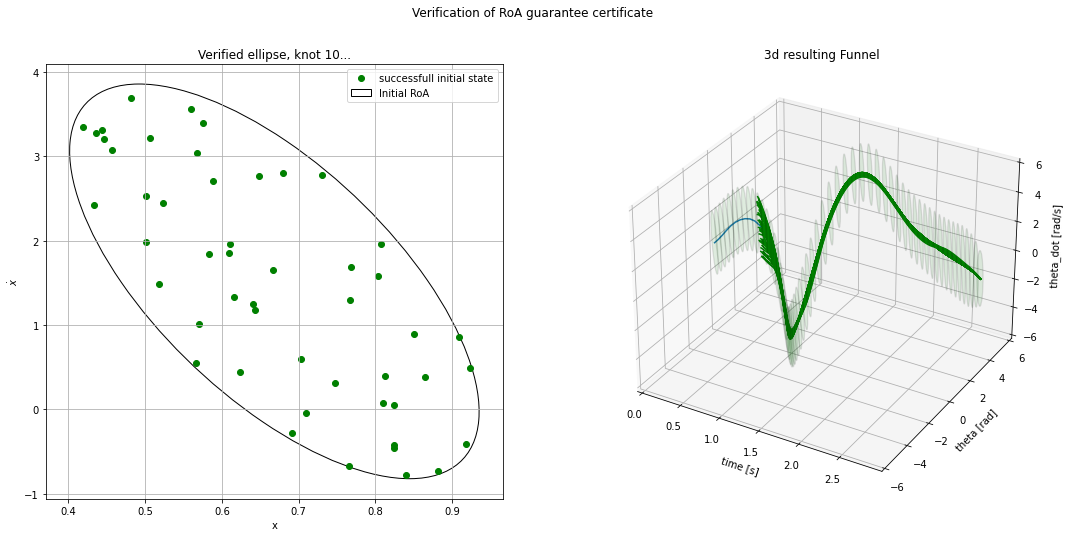

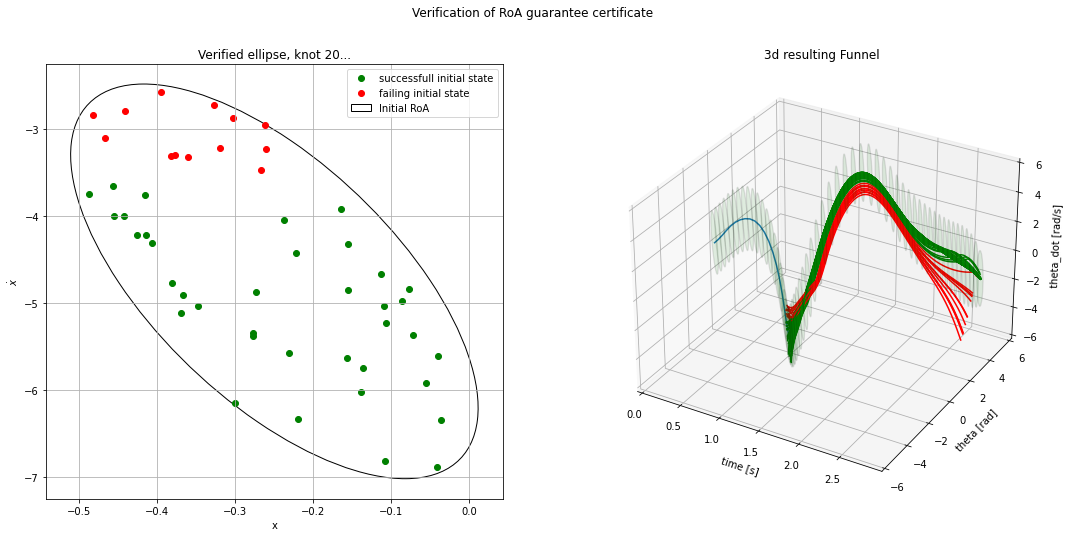

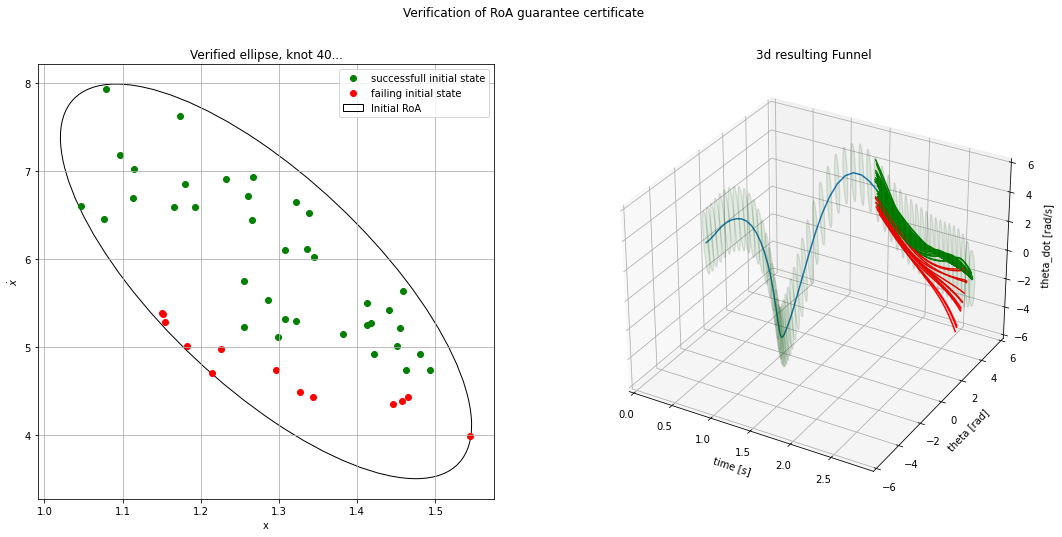

In [6]:
pendulum_approx = PendulumPlantApprox(mass=mass,
                                    length=length,
                                    damping=damping,
                                    gravity=gravity,
                                    coulomb_fric=coulomb_fric,
                                    inertia=None,
                                    torque_limit=torque_limit, 
                                    taylorApprox_order = 5, nominal_traj = x0_traj, time_traj = time)

print("Warning: The verification procedure takes time")
nSimulations = 50
tests = [0, 10,20,40]
for ver_idx in tests:
    print(f"Verification of the knot {ver_idx}...")
    # figure initialization
    fig = plt.figure(figsize=(18,8))
    fig.suptitle("Verification of RoA guarantee certificate")
    gs = fig.add_gridspec(1, 2)
    ax = fig.add_subplot(gs[0,0])
    ax.set_xlabel("x")
    ax.set_ylabel(r"$\dot{x}$")
 
    dt = 0.005 # simulation time interval

    # plot of the verified ellipse
    S_t = controller.tvlqr.S
    p = get_ellipse_patch(np.array(x0_traj).T[ver_idx][0],np.array(x0_traj).T[ver_idx][1],rho[ver_idx],S_t.value(time[ver_idx]),linec= "black")
    ax.add_patch(p)
    ax.grid(True)
    plt.title(f"Verified ellipse, knot {ver_idx}...")

    ax2 = fig.add_subplot(gs[0,1], projection='3d') 
    plotFunnel3d(rho, controller.tvlqr.S, x0_traj, time, ax2) # 3d funnel plot
    ax2.plot(time, x0_traj[0],x0_traj[1]) # plot the nominal traj

    one_green = False
    one_red = False
    for j in range(1,nSimulations+1):                                                                                                              

        xBar0=sample_from_ellipsoid(S_t.value(time[ver_idx]),rho[ver_idx]) # sample new initial state inside the estimated RoA
        x_i=xBar0+np.array(x0_traj).T[ver_idx] 

        sim = Simulator(plant=pendulum_approx) # init the simulation
        
        T, X, U = sim.simulate(time[ver_idx], x_i, time[-1], dt, controller) # simulating this interval 

        # plotting the checked initial states and resulting trajectories, the color depends on the result  
        finalJ = quad_form(S_t.value(time[-1]),X[-1]-np.array(x0_traj).T[-1])
       
        if (finalJ < rho[-1]):
            greenDot = ax.scatter([x_i[0]],[x_i[1]],color="green",marker="o")
            ax2.plot(T, np.array(X).T[0],np.array(X).T[1], color = "green")
            one_green = True
        else:
            redDot = ax.scatter([x_i[0]],[x_i[1]],color="red",marker="o")
            ax2.plot(T, np.array(X).T[0],np.array(X).T[1], color = "red")
            one_red = True

    # managing the dynamic legend of the plot
    if (one_green and one_red):
        ax.legend(handles = [greenDot,redDot,p], 
                    labels = ["successfull initial state","failing initial state", "Initial RoA"])
    elif ((not one_red) and one_green): 
        ax.legend(handles = [greenDot,p], 
                    labels = ["successfull initial state","Initial RoA"])
    else:
        ax.legend(handles = [redDot,p], 
                    labels = ["failing initial state","Initial RoA"])

plt.show()